In [1]:
#--- Install required package ---

!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.5 MB/s eta 0:00:00


In [2]:
# --- Download lec07_HWeq.py ---

!wget https://raw.githubusercontent.com/smaeyama/lec_SOKENDAI_Simulation_Science/main/fss2025/lec07_data_science/lec07_HWeq.py

--2025-04-15 15:16:09--  https://raw.githubusercontent.com/smaeyama/lec_SOKENDAI_Simulation_Science/main/fss2025/lec07_data_science/lec07_HWeq.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9007 (8.8K) [text/plain]
Saving to: ‘lec07_HWeq.py’

lec07_HWeq.py       100%[===================>]   8.80K  --.-KB/s    in 0s      

2025-04-15 15:16:09 (52.4 MB/s) - ‘lec07_HWeq.py’ saved [9007/9007]



## 1. Run Hasegawa-Wakatani plasma turbulence simulation

In [3]:
!python3 "lec07_HWeq.py"

Start 1D Hasegawa-Wakatani simulation.
Simulation complete.
Elapsed time [sec] : 330.2664678096771


In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Video
ds = xr.open_dataset("hasegawa_wakatani.nc")
print(ds)
t = np.array(ds.t)
x = np.array(ds.x)
y = np.array(ds.y)
dns = np.array(ds.dns)
phi = np.array(ds.phi)
ds.close()
print(phi.shape)

<xarray.Dataset> Size: 249MB
Dimensions:  (t: 1500, y: 96, x: 108)
Coordinates:
  * t        (t) float64 12kB 0.0 0.1 0.2 0.3 0.4 ... 149.6 149.7 149.8 149.9
  * y        (y) float64 768B -31.42 -30.76 -30.11 -29.45 ... 29.45 30.11 30.76
  * x        (x) float64 864B -31.42 -30.83 -30.25 -29.67 ... 29.67 30.25 30.83
Data variables:
    dns      (t, y, x) float64 124MB ...
    phi      (t, y, x) float64 124MB ...
(1500, 96, 108)


In [ ]:
# --- Animation ---
fig, ax = plt.subplots()
cax = ax.pcolormesh(x, y, dns[0], shading='auto', cmap='turbo')
cbar = fig.colorbar(cax)
ax.set_title(f"t = {t[0]:.2f}")

def update(i):
    cax.set_array(dns[i].ravel())
    vmax = np.max([dns[i].max(), -dns[i].min()])
    cax.set_clim(-vmax, vmax)
    ax.set_title(f"t = {t[i]:.2f}")
    return cax,

ani = FuncAnimation(fig, update, frames=range(0,len(t),1), interval=50)
ani.save("hasegawa_wakatani.mp4", writer="ffmpeg", dpi=100)
plt.close()

# --- Display in notebook ---
from IPython.display import Video
Video("hasegawa_wakatani.mp4", embed=True)

In [5]:
nx=len(x)
ny=len(y)
dx=x[1]-x[0]
dy=y[1]-y[0]
kx=np.fft.fftfreq(nx, dx/(2.0*np.pi))        # kx = 0, kx_min, 2*kx_min, ..., -2*kx_min, -kx_min
ky=np.fft.fftfreq(ny, dy/(2.0*np.pi))        # ky = 0, ky_min, 2*ky_min, ..., -2*ky_min, -ky_min
#print(kx)
print("Minimum wavenumber kx_min = ", kx[1])#, "(= 2pi/Lx =", 2.0*np.pi/(dx*nx),")")
print("Nyquist wavenumber kx_max = ", np.abs(kx).max())#, "(= pi/dx =", np.pi/dx,")")
#print(ky)
print("Minimum wavenumber ky_min = ", ky[1])#, "(= 2pi/Ly =", 2.0*np.pi/(dy*ny),")")
print("Nyquist wavenumber ky_max = ", np.abs(ky).max())#, "(= pi/dy =", np.pi/dy,")")

# Forward FFT with normalization (for our definition)
dnsk = np.fft.fft2(dns, axes=(-2,-1)) / (nx*ny)
phik = np.fft.fft2(phi, axes=(-2,-1)) / (nx*ny)
kx2, ky2 = np.meshgrid(kx, ky)
ksq = kx2**2 + ky2**2

Minimum wavenumber kx_min =  0.09999999999999991
Nyquist wavenumber kx_max =  5.399999999999995
Minimum wavenumber ky_min =  0.09999999999999998
Nyquist wavenumber ky_max =  4.799999999999999


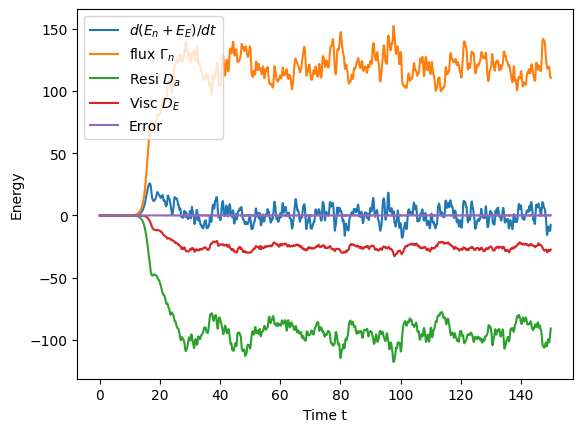

In [6]:
ca = 3.0           # adiabaticity parameter
eta = 5.0          # Density gradient
nu = 0.02          # Viscosity
flag_adiabaticity = "constant"


### Calculate energy balance equation ###
entrk = 0.5 * np.abs(dnsk)**2               # Entropy
eenek = 0.5 * ksq.reshape(1,ny,nx) * np.abs(phik)**2         # Electric field energy
entr = np.sum(entrk,axis = (1,2))
eene = np.sum(eenek,axis = (1,2))

enefluxk = eta * (1j * ky[None,:,None] * dnsk * phik.conjugate()).real                  # particle flux
eneresik = - ca * np.abs(phik - dnsk)**2                           # Dissipation by resistivity
enevisck = - nu * (ksq[None,:,:]**2 * np.abs(dnsk)**2 + ksq[None,:,:]**3 * np.abs(phik)**2)    # Dissipation by viscosity
eneflux = np.sum(enefluxk,axis = (1,2))
eneresi = np.sum(eneresik,axis = (1,2))
enevisc = np.sum(enevisck,axis = (1,2))


# d/dt (Entropy + Electric field energy) = Particle flux + Dissipation by resistivity + Dissipation by viscosity
# (t+dt + t)/2
dt = t[1] - t[0]
t_mid = (t[1:] + t[:-1]) / 2

dentr = np.diff(entr)
deene = np.diff(eene)
dedt = (dentr + deene) / dt

eneflux_mid = (eneflux[1:] + eneflux[:-1])/2
eneresi_mid = (eneresi[1:] + eneresi[:-1])/2
enevisc_mid = (enevisc[1:] + enevisc[:-1])/2

# Calculate energy balance error = LHS - RHS
eneerror = dedt - (eneflux_mid + eneresi_mid + enevisc_mid)

plt.plot(t_mid,dedt,label="$d(E_n+E_E)/dt$")
plt.plot(t_mid,eneflux_mid,label="flux $\Gamma_n$")
plt.plot(t_mid,eneresi_mid,label="Resi $D_a$")
plt.plot(t_mid,enevisc_mid,label="Visc $D_E$")
plt.plot(t_mid,eneerror,label="Error")
plt.xlabel("Time t")
plt.ylabel("Energy")
plt.legend()
plt.show()
#plt.savefig("energy_balance.png")

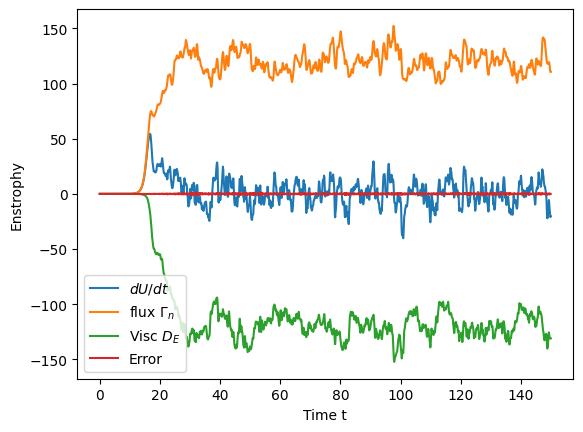

In [7]:
### Calculate enstrophy balance equation ###
enstk = 0.5 * np.abs(ksq[None,:,:] * phik + dnsk)**2     # Enstrophy
enst = np.sum(enstk,axis = (1,2))

enstfluxk = eta * (1j * ky[None,:,None] * (dnsk * phik.conjugate())).real    # particle flux
enstvisck = - nu * ksq[None,:,:]**2 * np.abs(ksq[None,:,:] * phik + dnsk)**2                                # Dissipation by viscosity
enstflux = np.sum(enstfluxk,axis = (1,2))
enstvisc = np.sum(enstvisck,axis = (1,2))

# d/dt (Enstrophy)　= (Enstrophy(t+dt) - Enstrophy(t)) / dt
denst = np.diff(enst)
dudt = denst/dt

enstflux_mid = (enstflux[1:] + enstflux[:-1])/2
enstvisc_mid = (enstvisc[1:] + enstvisc[:-1])/2

# Calculate enstrophy balance error = LHS - RHS
ensterror = dudt - (enstflux_mid + enstvisc_mid)

plt.plot(t_mid,dudt,label="$dU/dt$")
plt.plot(t_mid,enstflux_mid,label="flux $\Gamma_n$")
plt.plot(t_mid,enstvisc_mid,label="Visc $D_E$")
plt.plot(t_mid,ensterror,label="Error")
plt.xlabel("Time t")
plt.ylabel("Enstrophy")
plt.legend()
plt.show()
#plt.savefig("enstrophy_balance.png")

## 2. Data analysis: Spectrogram

<xarray.Dataset> Size: 249MB
Dimensions:  (t: 1500, y: 96, x: 108)
Coordinates:
  * t        (t) float64 12kB 0.0 0.1 0.2 0.3 0.4 ... 149.6 149.7 149.8 149.9
  * y        (y) float64 768B -31.42 -30.76 -30.11 -29.45 ... 29.45 30.11 30.76
  * x        (x) float64 864B -31.42 -30.83 -30.25 -29.67 ... 29.67 30.25 30.83
Data variables:
    dns      (t, y, x) float64 124MB ...
    phi      (t, y, x) float64 124MB ...
(1500, 96, 108)


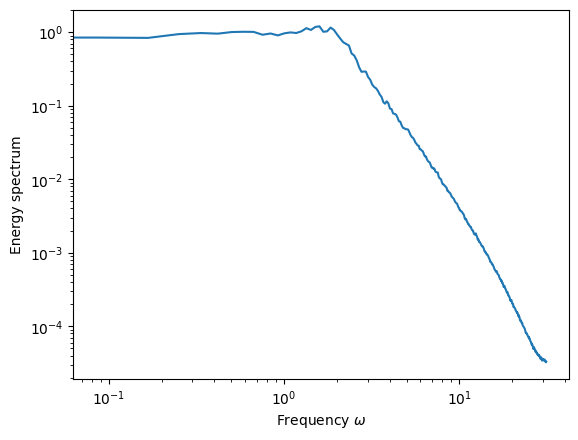

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
ds = xr.open_dataset("hasegawa_wakatani.nc")
print(ds)
t = np.array(ds.t)
x = np.array(ds.x)
y = np.array(ds.y)
dns = np.array(ds.dns)
phi = np.array(ds.phi)
ds.close()
print(phi.shape)

# --- Fourier transform ---
#  We physically assume the following equations:
#    Backward Fourier transform:
#      phi(t,y,x) = \sum_kx \sum_ky \sum_omega phi(omega,ky,kx) * exp(i*kx*x + i*ky*y - i*omega*t)
#    Forward Fourier transform:
#      phi(omega,ky,kx) = 1/(Lx*Ly*T) \int_dx \int_dy \int_dt phi(t,y,x) * exp(- i*kx*x - i*ky*y + i*omega*t)
#  Be careful with signature and definition of numpy.fft.fft and numpy.fft.ifft

# Wavenumber kx, ky
nx=len(x)
ny=len(y)
dx=x[1]-x[0]
dy=y[1]-y[0]
kx=np.fft.fftfreq(nx, dx/(2.0*np.pi))        # kx = 0, kx_min, 2*kx_min, ..., -2*kx_min, -kx_min
ky=np.fft.fftfreq(ny, dy/(2.0*np.pi))        # ky = 0, ky_min, 2*ky_min, ..., -2*ky_min, -ky_min

# Forward FFT in x, y (- sign with normalization)
phi_tkykx = np.fft.fft2(phi, axes=(1,2)) / (nx*ny)


def short_time_Fourier_transform(itsta, nwindow, t, phi_tkykx):
    # Frequency omega under a window function
    window_function = np.hanning(nwindow)
    phi_tkykx_window = phi_tkykx[itsta:itsta+nwindow,:,:] * window_function[:,None,None]

    dt=t[1]-t[0]
    omega=np.fft.fftfreq(nwindow, dt/(2.0*np.pi)) # omega = 0, omega_min, ..., -omega_min

    # Forward FFT in t (+ sign with normalization)
    phi_omegakykx = np.fft.ifft(phi_tkykx_window, axis=0)

    energy_spectrum = np.sum(np.abs(phi_omegakykx)**2, axis=(1,2))
    return t[itsta+nwindow//2], omega, energy_spectrum

nt=len(t)
dt = t[1] - t[0]
itsta = nt//3
nwindow = nt//2
t_window, omega, energy_spectrum = short_time_Fourier_transform(itsta, nwindow, t, phi_tkykx)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(omega[0:nwindow//2],energy_spectrum[0:nwindow//2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Frequency $\omega$")
ax.set_ylabel(r"Energy spectrum")
plt.show()

In [ ]:
nt=len(t)
nwindow = int(10.0 / dt)
t_spectrogram = []
spectrogram = []
for itsta in range(0,nt-nwindow,nwindow//10):
    t_window, omega, energy_spectrum = short_time_Fourier_transform(itsta, nwindow, t, phi_tkykx)
    t_spectrogram.append(t_window)
    spectrogram.append(energy_spectrum)
spectrogram = np.array(spectrogram)
t_spectrogram = np.array(t_spectrogram)

import matplotlib.colors as colors
omega_max = 20.0
nmax = np.argmax(omega > omega_max)
vmax = np.max(spectrogram)
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    omega[0:nmax],
    t_spectrogram,
    spectrogram[:, 0:nmax],
    norm=colors.LogNorm(vmin=vmax*1e-6, vmax=vmax),
    shading='auto'
)
plt.xlabel(r"Frequency $\omega$")
plt.ylabel("Time")
plt.colorbar(label="Energy spectrum")
plt.title(r"$t$-$\omega$ Spectrogram")
plt.show()

## 3. Data analysis: Singular value decomposition

In [ ]:
import xarray as xr
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
ds = xr.open_dataset("hasegawa_wakatani.nc")
print(ds)
t = np.array(ds.t)
x = np.array(ds.x)
y = np.array(ds.y)
dns = np.array(ds.dns)
phi = np.array(ds.phi)
ds.close()
print(phi.shape)

itsta = 500
wk_t = t[itsta:]
data = phi[itsta:]
ntime, ny, nx = data.shape
data = data.reshape(ntime,ny*nx)

U, Sigma, V_H = sp.linalg.svd(data,full_matrices=False)
print(data.shape,U.shape,Sigma.shape,V_H.shape)

In [ ]:
plt.plot(Sigma,".-")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mode number")
plt.ylabel(r"Singular value $\sigma$")
plt.ylim(1e-3*Sigma.max(),Sigma.max())
plt.show()

In [ ]:
def plot_mode_structure(idx, t, y, x, U, Sigma, V_H):
    SVD_amplitude = U[:,idx]*Sigma[idx] # Time evolution of amplitude
    SVD_mode = V_H[idx,:]               # Space mode structures, which are orthonormal.
    fig = plt.figure(figsize=(6,3))
    fig.suptitle(f"{idx}-th SVD mode structure and amplitude: "+r"$\sigma =$"+f"{Sigma[idx]:.2f}")
    ax = fig.add_subplot(121)
    ax.pcolormesh(x,y,SVD_mode.reshape(len(y),len(x)),cmap="jet")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax = fig.add_subplot(122)
    ax.plot(t,SVD_amplitude)
    ax.set_xlabel("t")
    ax.set_ylabel("SVD mode amplitude")
    fig.tight_layout()
    plt.show()

for idx in range(4):
    plot_mode_structure(idx, wk_t, y, x, U, Sigma, V_H)

In [ ]:
# --- Truncation for low-rank approximation ---
truncation=50
U_trunc=U[:,:truncation]       # Time
Sigma_trunc=Sigma[:truncation]
V_H_trunc = V_H[:truncation,:] # Space

SVD_amplitude_trunc = U*Sigma[np.newaxis,:] # Time evolution of amplitude
SVD_mode_trunc = V_H                        # Space mode structures, which are orthonormal.
print(SVD_amplitude_trunc.shape,SVD_mode_trunc.shape)
print("Raw data size = (ntime)x(ny)x(nx) = ({},{},{}) = {:,}".format(ntime,ny,nx,ntime*ny*nx))
print("Truncated size = (ntime)x(truncated_rank) + (truncated_rank)x(ny*nx) = ({},{})+({},{}) = {:,}".format(ntime,truncation,truncation,ny*nx,ntime*truncation+truncation*(ny*nx)))

reconstructed = SVD_amplitude_trunc @ SVD_mode_trunc
# print(reconstructed.shape, data.shape)

phi_rec = (reconstructed).reshape(ntime,ny,nx).real
phi_data = (data).reshape(ntime,ny,nx)
# print(phi_rec.shape, phi_data.shape)

In [ ]:
# --- Animation ---
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

x2, y2 = np.meshgrid(x,y)
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
title=fig.suptitle(r"$\phi(x,y)$ Time = {:5.2f}".format(wk_t[0]))
quad1=ax1.pcolormesh(x2, y2, phi_data[0,:-1,:-1],cmap="jet")
title1=ax1.set_title("Raw data")
vmax=np.max(np.abs(phi_data[0,:-1,:-1]))
quad1.set_clim(-vmax,vmax)
cbar1=fig.colorbar(quad1,shrink=1.0,aspect=10)
ax2 = fig.add_subplot(122)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
quad2=ax2.pcolormesh(x2, y2, phi_rec[0,:-1,:-1],cmap="jet")
title2=ax2.set_title("Reconstructed data")
quad2.set_clim(-vmax,vmax)
cbar2=fig.colorbar(quad2,shrink=1.0,aspect=10)
fig.tight_layout()

def update_quad(i):
    title.set_text(r"$\phi(x,y)$ Time = {:5.2f}".format(wk_t[i]))
    quad1.set_array(np.array([phi_data[i,:-1,:-1]]).flatten())
    vmax=np.max(np.abs(phi_data[i,:,:]))
    quad1.set_clim(-vmax,vmax)
    quad2.set_array(np.array([phi_rec[i,:-1,:-1]]).flatten())
    vmax=np.max(np.abs(phi_data[i,:,:]))
    quad2.set_clim(-vmax,vmax)

ani = FuncAnimation(fig, update_quad,
                    frames=range(0,len(wk_t)//2,2), interval=100)
ani.save("compare_svd_compression.mp4", writer="ffmpeg", dpi=100)
plt.close()

# --- Display in notebook ---
from IPython.display import Video
Video("compare_svd_compression.mp4", embed=True)